# Import Libraries

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # Prevent incompatible gpu

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Exploratory Data Analysis

In [3]:
ROOT = "../../datasets/"
SEED = 88
IMG_SIZE = (224, 224)    # load at original size first
BATCH_SIZE = 256
LABEL_MODE = "categorical" # one‑hot labels straight away

classes=["broccoli", "cauliflower", "unknown"]
splits=["test", "train", "validate"]

def load_split(split):
    dataset=tf.keras.preprocessing.image_dataset_from_directory(ROOT+split,
        seed        = SEED,
        image_size  = IMG_SIZE,
        batch_size  = BATCH_SIZE,
        label_mode  = LABEL_MODE)
    return dataset

train_ds_pre = load_split("train")
val_ds_pre = load_split("validate")
test_ds_pre = load_split("test")

Found 6212 files belonging to 3 classes.
Found 760 files belonging to 3 classes.
Found 761 files belonging to 3 classes.


,broccoli,cauliflower,unknown,splits total
test,257,272,232,761
train,2163,2191,1858,6212
validate,257,271,232,760
img total,2677,2734,2322,7733


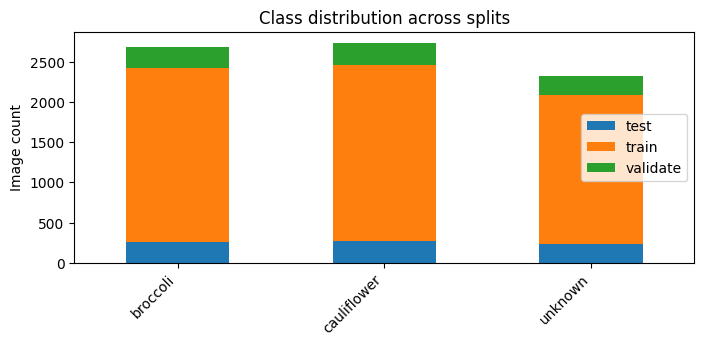

In [4]:
def count_images(split):
    return {cls: len(os.listdir(f"{ROOT}{split}/{cls}/"))
            for cls in classes}

df_counts = pd.DataFrame({s: count_images(s) for s in splits})

table_df = df_counts.T
table_df["splits total"] = table_df.sum(1)
table_df.loc["img total"] = table_df.sum(0)

display(table_df)  # Jupyter table

ax = df_counts.plot.bar(stacked=True, figsize=(8,3))
ax.set_title("Class distribution across splits")
ax.set_ylabel("Image count")
plt.xticks(rotation=45, ha="right")
plt.show()

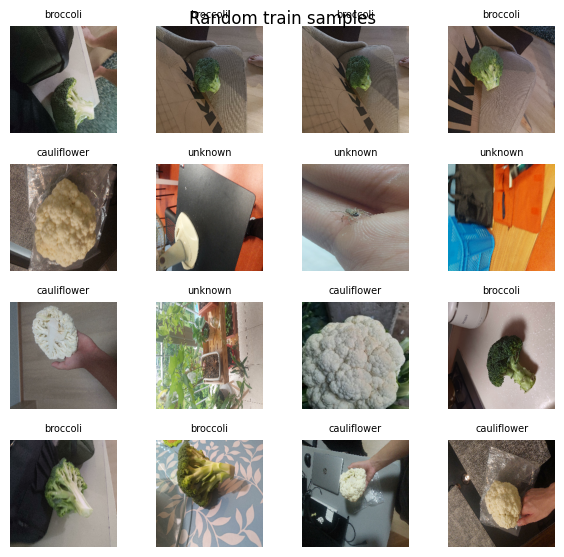

In [5]:
plt.figure(figsize=(6,6))
for images, labels in train_ds_pre.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")
plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [6]:
TARGET_SIZE = 100

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(TARGET_SIZE, TARGET_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomZoom((0.3), 0.3),
    layers.RandomBrightness(0.2, value_range=(0, 1))
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds_pre, shuffle=True, augment=True)
val_ds = prepare(val_ds_pre)
test_ds = prepare(test_ds_pre)

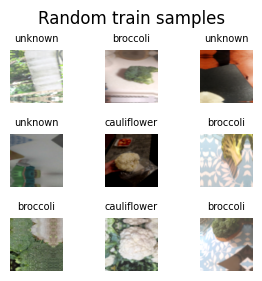

In [7]:
plt.figure(figsize=(3,3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")

plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Model building

In [8]:
num_classes = 3

model = keras.Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation="relu",
                 input_shape=(TARGET_SIZE, TARGET_SIZE,3)))

model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D((2,2)))   # 50→25
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))

model.add(layers.Conv2D(256, (3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D((2,2)))   # 12→6
model.add(layers.Dropout(0.3))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(num_classes, activation="softmax"))

model.summary()

Optimizer = optimizers.Adam(0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Optimizer,
              metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 256)       295168    
                                                      

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [10]:
history = model.fit(
    train_ds,
    epochs=40,
    verbose=1,
    validation_data = val_ds,
    callbacks=[early_stop]
)

score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


model.save_weights('model_weights.hdf5')
tf.keras.models.save_model(model,'model.hdf5')

Epoch 1/40
25/25 [==============================] - 548s 18s/step - loss: 1.0966 - accuracy: 0.3496 - val_loss: 1.0801 - val_accuracy: 0.4947
Epoch 2/40
25/25 [==============================] - 342s 10s/step - loss: 1.0433 - accuracy: 0.4652 - val_loss: 0.9968 - val_accuracy: 0.5276
Epoch 3/40
25/25 [==============================] - 350s 10s/step - loss: 1.0143 - accuracy: 0.4860 - val_loss: 0.9248 - val_accuracy: 0.5855
Epoch 4/40
25/25 [==============================] - 673s 24s/step - loss: 0.9437 - accuracy: 0.5382 - val_loss: 0.8626 - val_accuracy: 0.6118
Epoch 5/40
25/25 [==============================] - 1107s 42s/step - loss: 0.8846 - accuracy: 0.5963 - val_loss: 0.8396 - val_accuracy: 0.6263
Epoch 6/40
25/25 [==============================] - 1034s 19s/step - loss: 0.8163 - accuracy: 0.6660 - val_loss: 0.7692 - val_accuracy: 0.7132
Epoch 7/40
25/25 [==============================] - 500s 15s/step - loss: 0.7381 - accuracy: 0.7149 - val_loss: 0.6067 - val_accuracy: 0.7882
Epoc

# Model Evalutation

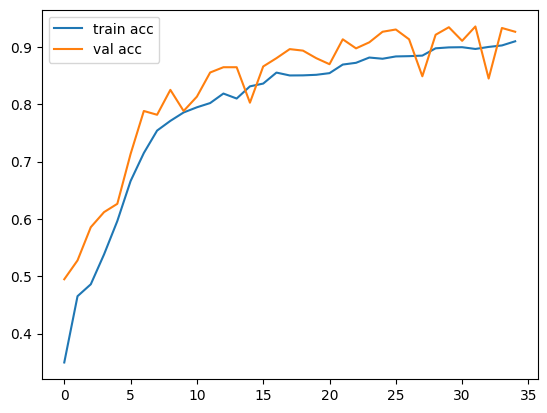

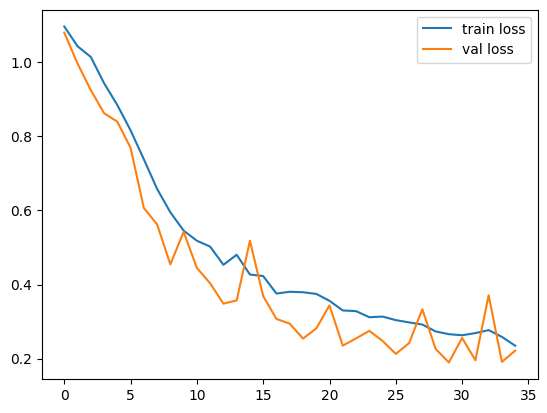

In [11]:
pd.DataFrame(history.history).to_csv("hist.csv", index=False)

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

8/8 [==============================] - 1s 136ms/step
Broccoli Precision:  0.8949416342412452
Broccoli Recall :  0.9465020576131687

Cauliflower Precision:  0.9522058823529411
Cauliflower Recall:  0.9384057971014492

Unknown Precision:  0.9224137931034483
Unknown Recall:  0.8842975206611571


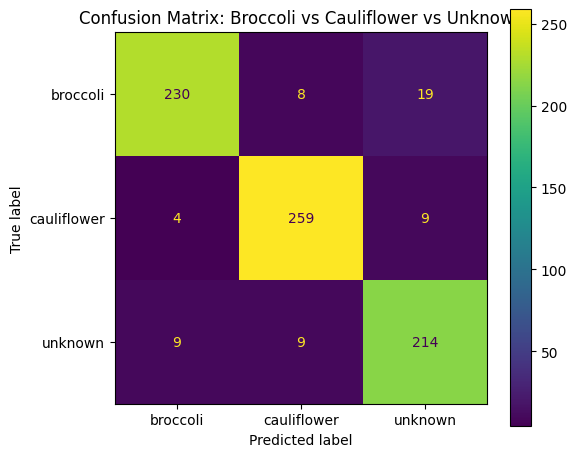

In [12]:
model = tf.keras.models.load_model('./model.hdf5')

y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = np.argmax(tf.concat([item for item in y_true], axis = 0), axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = confusion_matrix(correct_labels, predicted_labels)
print("Broccoli Precision: ", cm[0][0] / cm[0].sum())
print("Broccoli Recall : ", cm[0][0] / cm.T[0].sum())
print()
print("Cauliflower Precision: ", cm[1][1] / cm[1].sum())
print("Cauliflower Recall: ", cm[1][1] / cm.T[1].sum())
print()
print("Unknown Precision: ", cm[2][2] / cm[2].sum())
print("Unknown Recall: ", cm[2][2] / cm.T[2].sum())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax)
plt.title('Confusion Matrix: Broccoli vs Cauliflower vs Unknown')
plt.tight_layout()
plt.show()